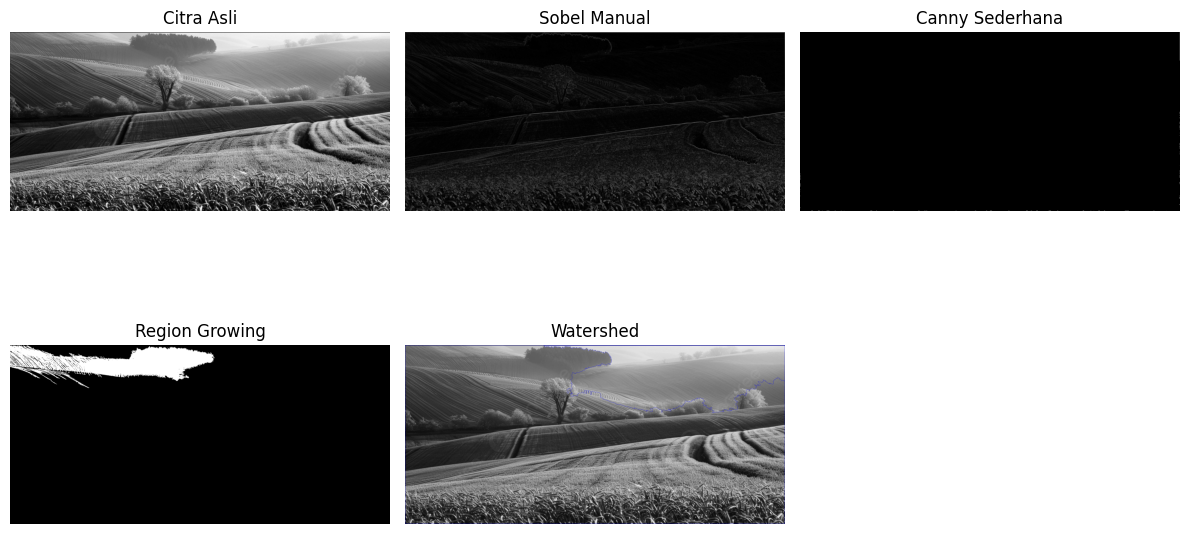

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# 1. LOAD GAMBAR
# ==============================
img = cv2.imread('gambar_uji.png', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Gambar tidak ditemukan! Pastikan 'gambar_uji.jpg' ada di folder.")

# ==============================
# 2. SOBEL EDGE DETECTION (manual version)
# ==============================
def sobel_manual(image):
    # Kernel Sobel horizontal & vertikal
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]])

    # Padding gambar supaya konvolusi tidak mengurangi ukuran
    padded = np.pad(image, ((1,1),(1,1)), mode='constant')
    Gx = np.zeros_like(image, dtype=float)
    Gy = np.zeros_like(image, dtype=float)

    # Konvolusi manual
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+3, j:j+3]
            Gx[i,j] = np.sum(region * Kx)
            Gy[i,j] = np.sum(region * Ky)

    magnitude = np.sqrt(Gx**2 + Gy**2)
    magnitude = (magnitude / magnitude.max() * 255).astype(np.uint8)
    return magnitude

sobel_result = sobel_manual(img)

# ==============================
# 3. CANNY SEDERHANA (tanpa library khusus)
# ==============================
def simple_canny(image, low, high):
    # Step 1: Gaussian blur manual
    kernel = np.array([[1,2,1],[2,4,2],[1,2,1]]) / 16
    padded = np.pad(image, ((1,1),(1,1)), mode='reflect')
    blurred = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            blurred[i,j] = np.sum(padded[i:i+3, j:j+3] * kernel)

    # Step 2: Sobel untuk gradient
    edge = sobel_manual(blurred.astype(np.uint8))

    # Step 3: Threshold dua nilai
    strong_edges = (edge > high).astype(np.uint8)
    weak_edges = ((edge >= low) & (edge <= high)).astype(np.uint8)

    # Step 4: Hysteresis sederhana (weak yang terhubung ke strong menjadi tepi)
    result = np.copy(strong_edges)
    for i in range(1, edge.shape[0]-1):
        for j in range(1, edge.shape[1]-1):
            if weak_edges[i,j]:
                if np.any(strong_edges[i-1:i+2, j-1:j+2]):
                    result[i,j] = 1
    return (result * 255).astype(np.uint8)

canny_result = simple_canny(img, 50, 150)

# ==============================
# 4. REGION GROWING (dari satu titik seed)
# ==============================
def region_growing_manual(image, seed, threshold=10):
    visited = np.zeros_like(image)
    region = []
    queue = [seed]
    seed_value = int(image[seed])
    while queue:
        x, y = queue.pop(0)
        if visited[x, y] == 0:
            if abs(int(image[x, y]) - seed_value) < threshold:
                region.append((x, y))
                visited[x, y] = 1
                # Tambahkan tetangga 4 arah
                for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
                    nx, ny = x+dx, y+dy
                    if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1]:
                        queue.append((nx, ny))
    mask = np.zeros_like(image)
    for (x, y) in region:
        mask[x, y] = 255
    return mask

region_result = region_growing_manual(img, seed=(100,100), threshold=15)

# ==============================
# 5. WATERSHED SEDERHANA (logika topografi manual)
# ==============================
def simple_watershed(image):
    blur = cv2.GaussianBlur(image, (5,5), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.6*dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(binary, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0
    color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(color, markers)
    color[markers == -1] = [255,0,0]
    return cv2.cvtColor(color, cv2.COLOR_BGR2RGB)

watershed_result = simple_watershed(img)

# ==============================
# 6. TAMPILKAN SEMUA HASIL
# ==============================
titles = ['Citra Asli', 'Sobel Manual', 'Canny Sederhana', 'Region Growing', 'Watershed']
images = [img, sobel_result, canny_result, region_result, watershed_result]

plt.figure(figsize=(12,7))
for i in range(5):
    plt.subplot(2,3,i+1)
    if i == 4:
        plt.imshow(images[i])
    else:
        plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
